In [633]:
import time 

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import expsolve as es
import expsolve.discretize.tensorgrid as ex

import torch
from torch import exp, kron, eye, sin, cos, abs, real, imag, pi, max, diag
from torch.linalg import norm, matrix_exp


from IPython.display import display, Markdown

In [4]:
n = 200
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr)

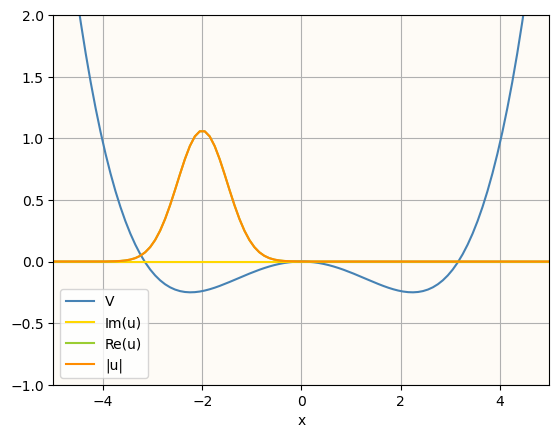

In [5]:
x0 = -2.0
u0 = exp(-(x-x0)**2/(2*0.25))
u0 = ex.normalize(u0, xr)    

V = x**4 - 10*x**2

linespecs = lambda u: [((x, V/100), {'color':mcolors.CSS4_COLORS['steelblue']}, 'V'), 
             ((x, imag(u)), {'color':mcolors.CSS4_COLORS['gold']}, 'Im(u)'),
             ((x, real(u)), {'color':mcolors.CSS4_COLORS['yellowgreen']}, 'Re(u)'),
             ((x, abs(u)), {'color':mcolors.CSS4_COLORS['darkorange']}, '|u|')]

fig, ax = plt.subplots()
ex.plot(ax, linespecs=linespecs(u0), xlim=[-5,5], ylim=[-1,2], xlabel='x')
plt.show()

In [501]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import RegularPolygon, Circle
import matplotlib.colors as mcolors
from matplotlib.collections import PatchCollection

In [575]:
from itertools import product

h = 1
r = 10

def honeycombgrid(h, n, active = lambda x, y: True, cx = [0., 0.]):
    cx = np.array(cx)
    c = (h/np.sqrt(3))*np.array([(col * 3/2, (row + (1/2 if col%2==1 else 0)) * np.sqrt(3)) for (col, row) in product(range(n[0]), range(n[1]))])
    ct = c.T
    cr = np.array([[np.min(ct[0]), np.max(ct[0])], [np.min(ct[1]), np.max(ct[1])]])
    cav = np.array([(cr[0][0] + cr[0][1])/2, (cr[1][0] + cr[1][1])/2])
    c  = c - cav.T + cx.T
    centers = np.array([(x,y) for (x,y) in c if active(x,y)])
    ct = centers.T
    cr = np.array([[np.min(ct[0]), np.max(ct[0])], [np.min(ct[1]), np.max(ct[1])]])
    xr =  cr + h*np.array([[-1/np.sqrt(3)-0.05, 1/np.sqrt(3)+0.05], [-0.5, 0.5]])
    nc = len(centers)
    
    c = fibre.T
    cx = c[0].unsqueeze(0)
    cy = c[1].unsqueeze(0)
    dist = torch.sqrt((cx - cx.T)**2 + (cy - cy.T)**2)
    return torch.tensor(centers), torch.tensor(xr), nc, dist

fibre, xr, nc, dist = honeycombgrid(h, n=[int(np.ceil((4/np.sqrt(3))*r)), 2*r], active = lambda x,y: (x**2 + y**2 <= (r*h)**2) )

In [577]:
xr

tensor([[-10.5866,  10.5866],
        [-10.2500,  10.2500]], dtype=torch.float64)

In [578]:
nc
u = torch.rand(nc, dtype=torch.complex128)

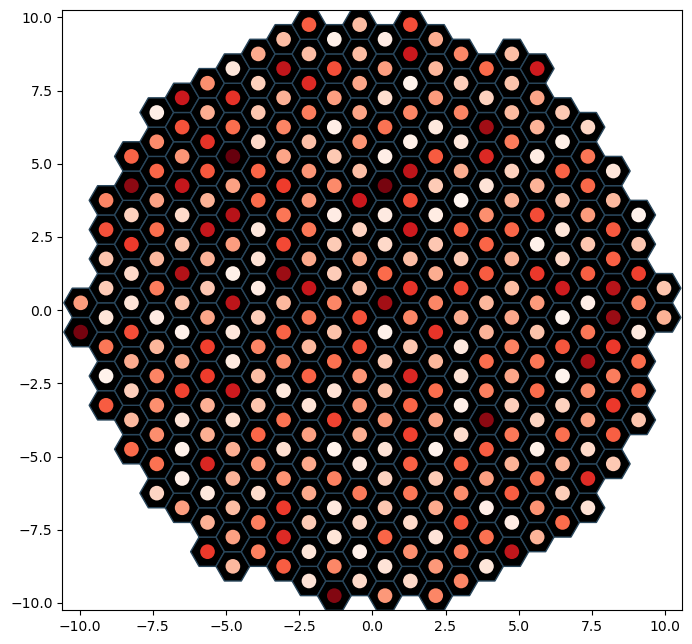

In [556]:

def drawhoneycomb(ax, h, centers, facecolor=mcolors.XKCD_COLORS['xkcd:black'], edgecolor=mcolors.XKCD_COLORS['xkcd:dark grey blue']):
    hexagons =[RegularPolygon(center, numVertices=6, radius=h/np.sqrt(3), orientation=torch.pi/6) for center in centers]
    hexagon_collection = PatchCollection(hexagons, color=facecolor, edgecolor=edgecolor)
    ax.add_collection(hexagon_collection)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal', 'box')
drawhoneycomb(ax, h, fibre)

ax.set_xlim(xr[0][0], xr[0][1])
ax.set_ylim(xr[1][0], xr[1][1])

def drawactivation(ax, h, centers, u, activations=None):
    intensities = torch.abs(u)**2

    if activations is None:
        circles =[Circle(xy=(x, y), radius=h/4) for (x,y) in centers]
        activations = PatchCollection(circles, cmap=plt.cm.Reds)
        activations.set_array(intensities)
        ax.add_collection(activations)
        return activations
    else:
        activations.set_array(intensities)
        return activations

activations = drawactivation(ax, h, fibre, u)
drawactivation(ax, h, fibre, u, activations)

plt.show()

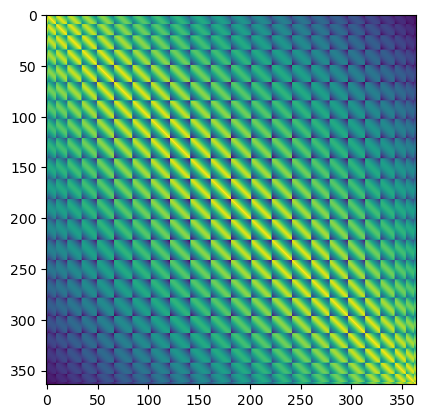

In [606]:
c = 2.
plt.imshow(torch.log(exp(-c*dist/h)))
plt.show()

In [607]:
exp(-c*dist/h)[0,6]

tensor(0.0313, dtype=torch.float64)

In [609]:
torch.randn(5)

tensor([-0.2325, -0.2240, -0.4335,  2.1728, -0.6048])

In [614]:
H = exp(-c*dist/h) + 0.1*torch.diag(torch.randn(nc))

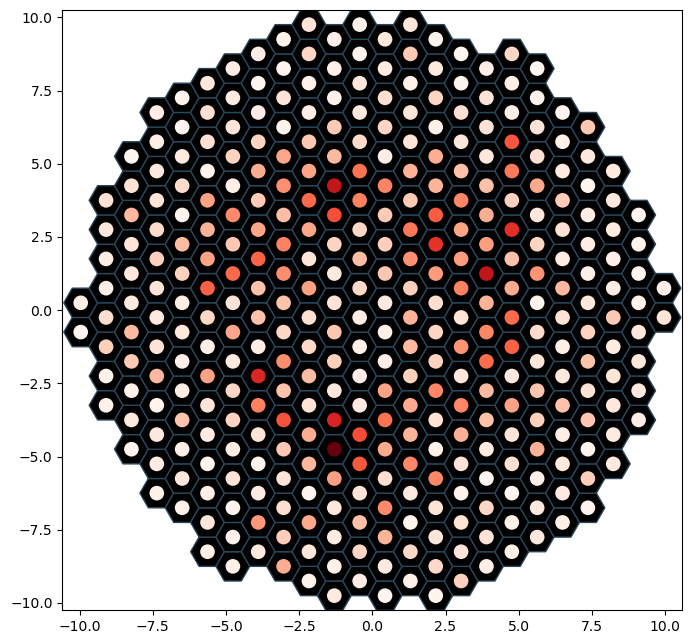

In [630]:
L = 10
uT = torch.matrix_exp(-1j*L*H) @ u


fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal', 'box')
drawhoneycomb(ax, h, fibre)

ax.set_xlim(xr[0][0], xr[0][1])
ax.set_ylim(xr[1][0], xr[1][1])

activations = drawactivation(ax, h, fibre, uT)
plt.show()

In [631]:
exactstep = lambda t, h, u0: torch.matrix_exp(-1j*h*H) @ u0 

L = 50
trange = [0, L]
timegrid = es.timegrid(trange, ndt=1000)

uT, obsvalues, uintermediate = es.solvediffeq(u, timegrid, exactstep, observables = {}, storeintermediate = True)

In [634]:
def drawall(ax, u):
    # ax.set_aspect('equal', 'box')
    drawhoneycomb(ax, h, fibre)
    drawactivation(ax, h, fibre, u)

    ax.set_xlim(xr[0][0], xr[0][1])
    ax.set_ylim(xr[1][0], xr[1][1])

drawframe = lambda ax, frame: drawall(ax, uintermediate[frame])
outputgif = 'fibre.gif'
es.animate(drawframe, len(uintermediate), outputgif, speedfactor=5, border=False, size=(800, 800))
display(Markdown(f'![gif]({outputgif})'))


![gif](fibre.gif)

In [640]:
K = 1
nonlinearstep = lambda t, h, u0: torch.matrix_exp(-1j*h*(H + K*torch.diag(abs(u0)**2))) @ u0 

L = 10
trange = [0, L]
timegrid = es.timegrid(trange, ndt=100)

uT, obsvalues, uintermediateNLS = es.solvediffeq(u, timegrid, nonlinearstep, observables = {}, storeintermediate = True)


In [641]:
drawframe = lambda ax, frame: drawall(ax, uintermediateNLS[frame])
outputgif = 'fibreNLSslow.gif'
es.animate(drawframe, len(uintermediateNLS), outputgif, speedfactor=1, border=False, size=(800, 800))
display(Markdown(f'![gif]({outputgif})'))

![gif](fibreNLSslow.gif)